# Tree direction test

In [41]:
import pandas as pd
import numpy as np

In [11]:
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [42]:
import tree_test_utilities.flu_trees_statistics_calculator as flu_trees_statistics_calculator
import tree_test_utilities.tree_test_utilities as tree_test_utilities
import likelihood_calculator.likelihood_calculator as likelihood_calculator
import shm_kmer_model.shm_kmer_model as shm_kmer_model

In [153]:
flu_calc = flu_trees_statistics_calculator.FluTreesStatisticsCalculator()
tester = tree_test_utilities.TreeTester(minimal_size_filtered_tree=15)

In [154]:
mutability_results   = flu_calc.get_flu_likelihood_statistics(tester, model_mode=shm_kmer_model.ModelMode.Mutation)
substitution_results = flu_calc.get_flu_likelihood_statistics(tester, model_mode=shm_kmer_model.ModelMode.Substitution)
mut_subst_results    = flu_calc.get_flu_likelihood_statistics(tester, model_mode=shm_kmer_model.ModelMode.Both)

In [155]:
print(mutability_results['Yale']['NoKNeighbours'][30][0])
print(substitution_results['Yale']['NoKNeighbours'][30][0])
print(mut_subst_results['Yale']['NoKNeighbours'][30][0])

(-5.02709596677701, -5.133498545651392)
(-1.49574763978407, -1.2707916154029102)
(-6.52284360656108, -6.404290161054302)


In [201]:
accuracy    = np.vectorize(lambda x: x[0] < x[1])
logloss     = np.vectorize(lambda x: x[0] - np.log(np.exp(x[0]) + np.exp(x[1])))
reliability = np.vectorize(lambda x: np.exp(x[0] - x[1]))

def apply_statistic_to_dataset(dataset, statistic, aggregate):
    results = []
    for tree in dataset:
        if len(tree):
            results.append(aggregate(statistic(tree)))
    return np.array(results)

def draw_classification_stats_distplot(x1, x2, bins=10):
    draw_distplot = (lambda x: sns.distplot(x[~np.isnan(x)], bins=bins, rug=True, kde=True))
    draw_distplot(x1)
    draw_distplot(x2)

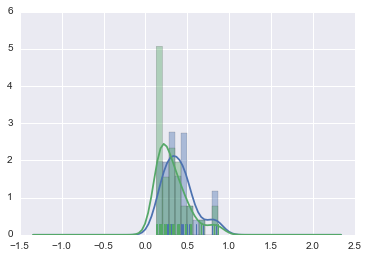

In [202]:
accuracy_yale = apply_statistic_to_dataset(mut_subst_results['Yale']['Trivial'], accuracy, np.mean)
accuracy_cab  = apply_statistic_to_dataset(mut_subst_results['CAB_NoKNeighbours']['Trivial'], accuracy, np.mean)
draw_classification_stats_distplot(accuracy_yale, accuracy_cab)

In [158]:
import scipy as sp
sp.stats.mannwhitneyu(accuracy_yale, accuracy_cab, use_continuity=True)

MannwhitneyuResult(statistic=787.0, pvalue=0.040943059618458622)

In [159]:
print(np.median(accuracy_yale), np.median(accuracy_cab))
print(np.mean(accuracy_yale), np.mean(accuracy_cab))

(0.38461538461538464, 0.27777777777777779)
(0.40091384252653522, 0.32470252664578819)


In [160]:
x = apply_statistic_to_dataset(mut_subst_results['CAB_NoKNeighbours']['Trivial'], accuracy, lambda x: x)
np.mean(np.concatenate(x))

0.2899746192893401

In [161]:
x = apply_statistic_to_dataset(mut_subst_results['Yale']['Trivial'], accuracy, lambda x: x)
np.mean(np.concatenate(x))

0.4016497461928934

-1201.13918617
-931.115785915


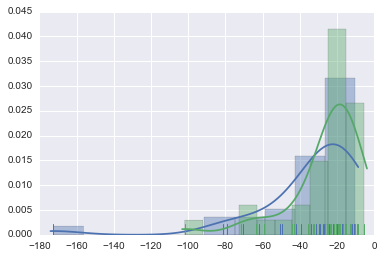

In [212]:
logloss_yale = apply_statistic_to_dataset(mut_subst_results['Yale']['Trivial'], logloss, np.sum)
logloss_cab  = apply_statistic_to_dataset(mut_subst_results['CAB_NoKNeighbours']['Trivial'], logloss, np.nansum)
draw_classification_stats_distplot(logloss_yale, logloss_cab)
print(np.sum(logloss_yale))
print(np.sum(logloss_cab))

In [213]:
sp.stats.mannwhitneyu(logloss_yale, logloss_cab, use_continuity=True)

MannwhitneyuResult(statistic=498.0, pvalue=0.18055292895708219)

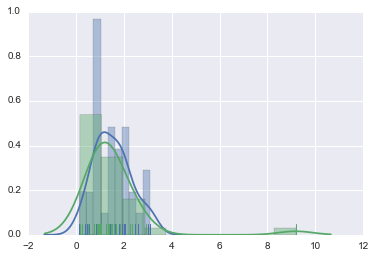

In [214]:
reliability_yale = apply_statistic_to_dataset(mut_subst_results['Yale']['Trivial'], reliability, np.median)
reliability_cab  = apply_statistic_to_dataset(mut_subst_results['CAB_NoKNeighbours']['Trivial'], reliability, np.nanmedian)
reliability_yale
draw_classification_stats_distplot(reliability_yale, reliability_cab)

In [215]:
sp.stats.mannwhitneyu(reliability_yale, reliability_cab, use_continuity=True)

MannwhitneyuResult(statistic=689.0, pvalue=0.37045025756825478)

In [210]:
np.median(reliability_yale)

1.4504645824287379

In [211]:
np.median(reliability_cab)

1.2527441537103976

## ROC

In [75]:
from sklearn.metrics import roc_curve, auc

In [80]:
np.concatenate(mut_subst_results['Yale']['Trivial'])

array([(-6.52284360656108, -6.404290161054302),
       (-2.484074267477377, -2.261477588148975),
       (-4.628397292918708, -2.433345431188785), ...,
       (-2.248557434189702, -2.465226015084215),
       (-6.552054773125556, -4.861758996657733),
       (-5.848086687274996, -4.86372110176286)], 
      dtype=[('f0', '<f8'), ('f1', '<f8')])

In [112]:
def plot_roc(predicted_proba):
    predicted_proba = np.copy(predicted_proba)
    predicted_proba = np.concatenate(predicted_proba)
    logloss = np.vectorize(lambda x: x[0] - np.log(np.exp(x[0]) + np.exp(x[1])))

    predicted_proba = logloss(predicted_proba)
    predicted_proba = np.exp(predicted_proba)
    
    print(np.mean(predicted_proba))
    answers = np.zeros(len(predicted_proba))
    answers[0:(len(predicted_proba) / 2)] = 1
    fpr, tpr, thresholds = roc_curve(answers, predicted_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)' % (roc_auc))

nan


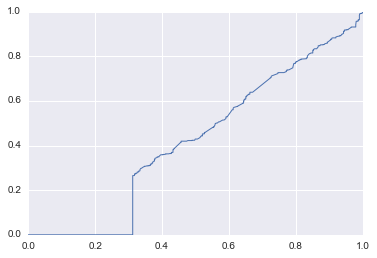

In [113]:
plot_roc(mut_subst_results['CAB_NoKNeighbours']['Trivial'])